In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


# Intro

- The calculation of sheath dz was wrong in my edge neutral cooling BC
- This was responsible for the 0 cooling at the PFR

# Hermes IO

In [2]:
casestore = dict()
db = CaseDB()

In [3]:
db = CaseDB()

toload = [
    dict(name="base", id="d16h-afn_with_edgerefl_proper", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="fastrec", id="d16hb-fast_recycling", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),

]

for case in toload:
    print(f"Loading {case}...")
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

Loading {'name': 'base', 'id': 'd16h-afn_with_edgerefl_proper', 'grid': 'g3b2-fatter_newhypno.nc', 'unnormalise_geom': True}...
CHECK: Total domain volume is 1.942E+00 [m3]
Loading {'name': 'fastrec', 'id': 'd16hb-fast_recycling', 'grid': 'g3b2-fatter_newhypno.nc', 'unnormalise_geom': True}...
CHECK: Total domain volume is 1.942E+00 [m3]


In [4]:
plt.close("all")
%matplotlib inline

In [5]:
# write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\wall_cooling_analysis.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\wall_cooling_analysis.pkl written


In [11]:
# casestore = read_file(r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\wall_cooling_analysis.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\wall_cooling_analysis.pkl loaded


## Read Hermes data

In [4]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

base
fastrec


# Read SOLEDGE CSV data

In [5]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



In [24]:
path = soledgecases["nocore_d"]
sl["nocore_d"].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

## Read SOLPS

In [6]:
solpscases = {
    "base" : os.path.join(onedrive_path,           r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path,      r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path,     r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path,     r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path,     r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,      r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path,      r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path,    r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path,        r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

In [ ]:
solps = sp["nsep_2e19"].regions["omp"]["rfluxa3da"]

In [7]:
for name in casestore:

    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds)



# Lineplots

In [8]:
plt.close("all")
%matplotlib inline

In [11]:
hr.keys()

dict_keys(['escapecore', 'condsol', 'neutralbc', 'gamma0.4', 'halfcond', 'pump', 'fixes'])

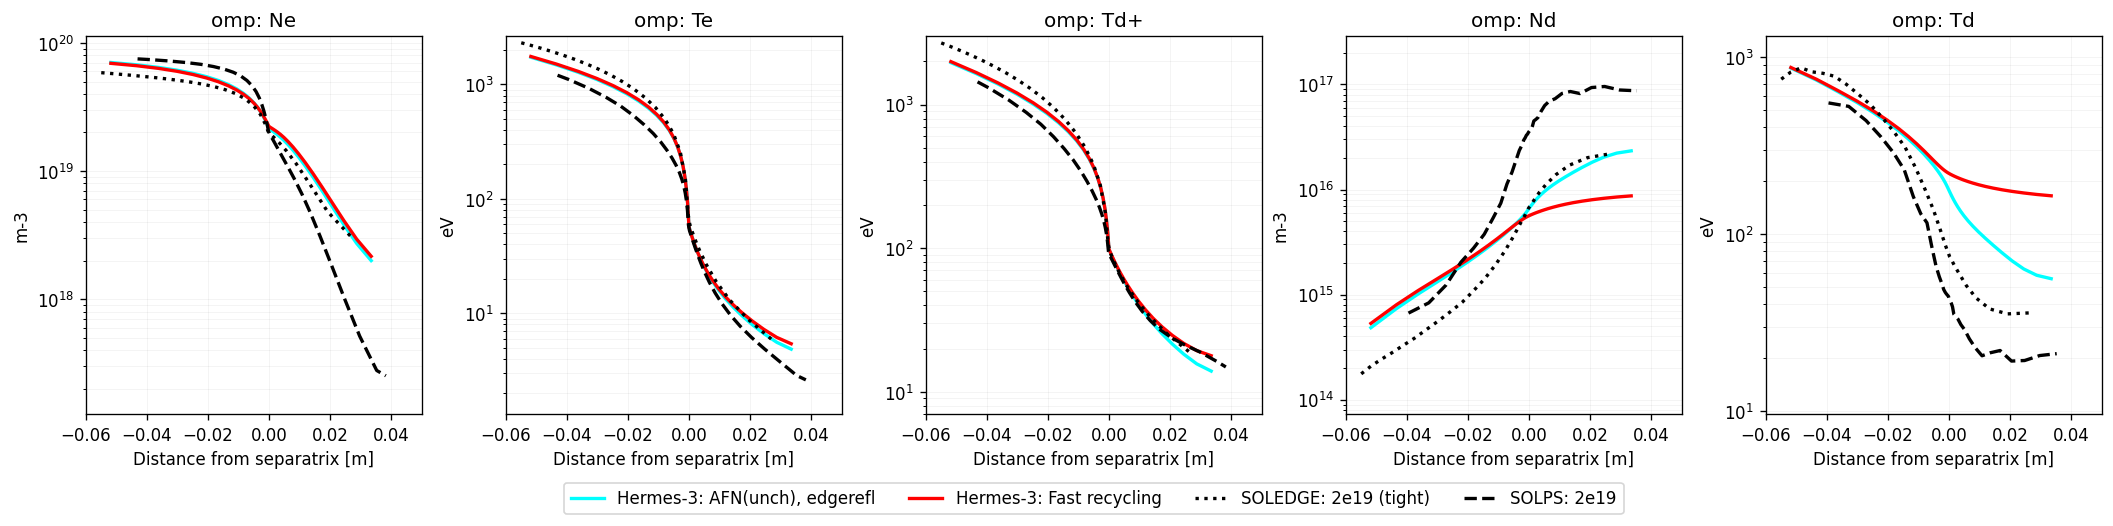

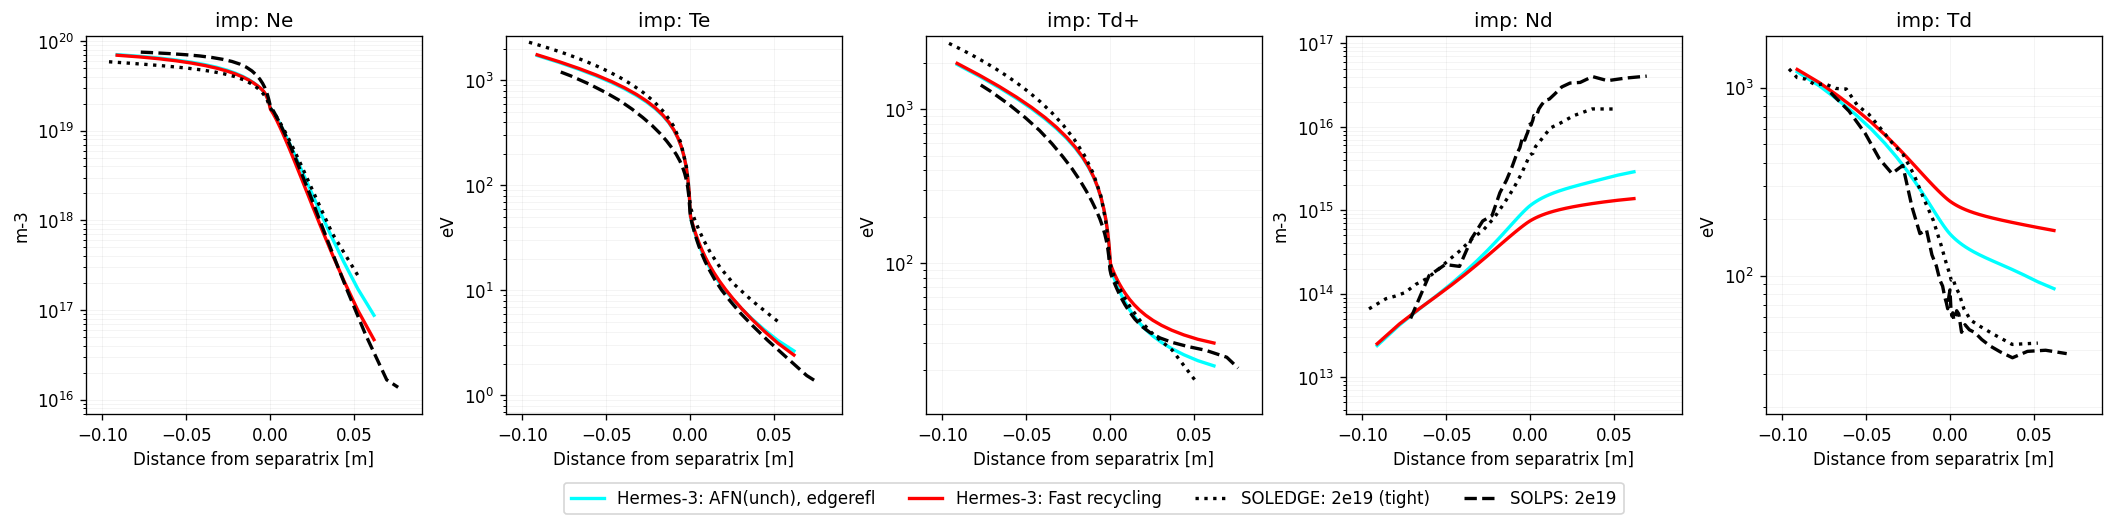

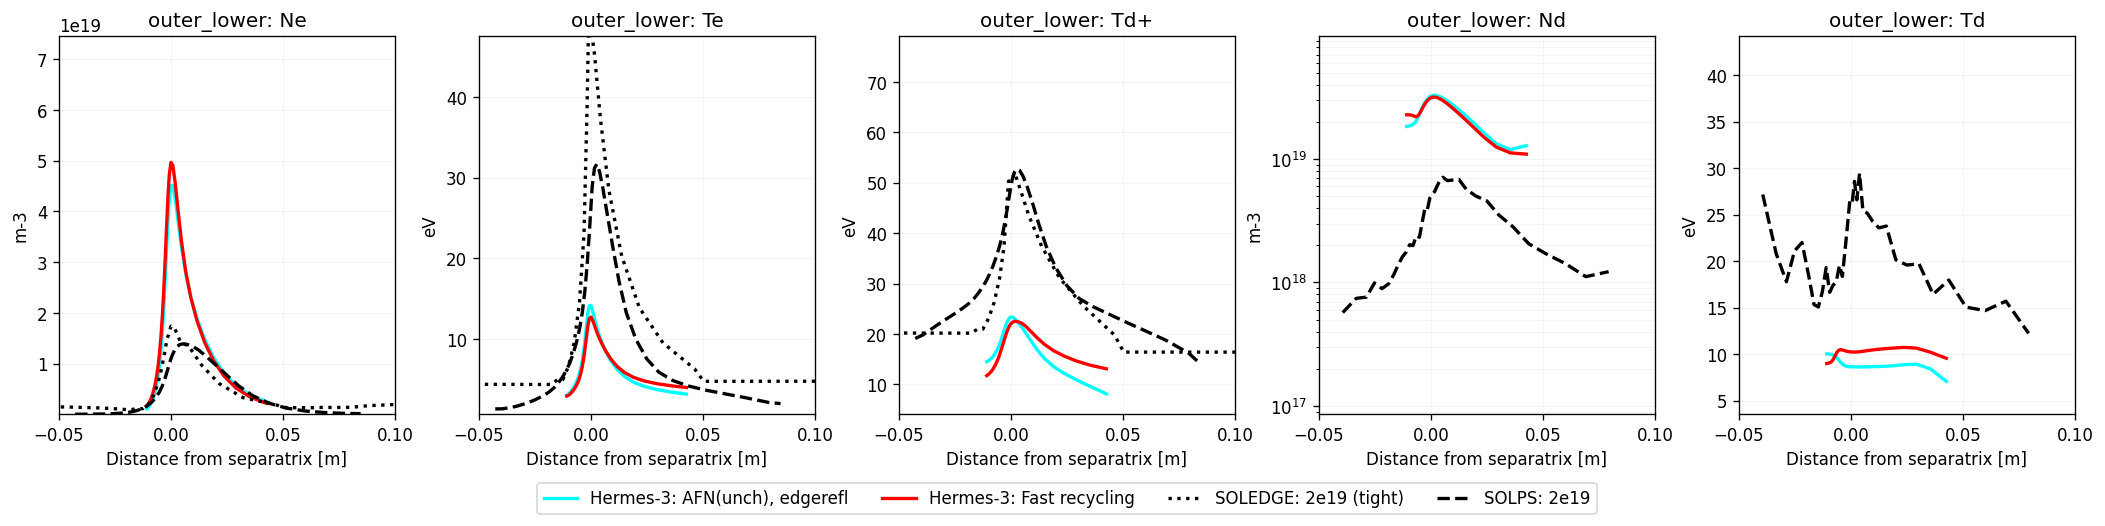

In [9]:

plt.close("all")
lineplot_compare(
    cases = { 

    "Hermes-3: AFN(unch), edgerefl": dict(data=hr["base"], color = "cyan"),
    "Hermes-3: Fast recycling": dict(data=hr["fastrec"], color = "red"),
    
    # "SOLEDGE: 1e19 (tight)" : dict(data=sl["tightwall_1e19"], color="#3288bd"),
    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    
    # "SOLEDGE: 1e19" : dict(data=sl["widewall_1e19"], color = "blue"),
    # "SOLEDGE: 2e19" : dict(data=sl["widewall_2e19"], color = "red")
    "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="black"),

    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp"], params = ["Ne", "Nd",  "Te"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 120,
    lw = 2
)

In [37]:
np.sqrt(constants("k_b") / constants("mass_p")) * 3.638

330.5258381664805

In [32]:
ds = casestore["base"].ds.isel(t=-1)

if ds["t"].shape != ():
    raise Exception("Please supply a single time slice")
places = {}

places["inner_wall  "] = ds.hermesm.select_region("inner_sol_edge")
places["outer_wall  "] = ds.hermesm.select_region("outer_sol_edge")
places["pfr         "] = ds.hermesm.select_region("pfr_edge")

if "Ed_wall_refl" in ds.data_vars:
    hflows = {}
    for place in places:
        ds_place = places[place]
        hflows[place] = ()
        hflows[place] = (ds_place["Ed_wall_refl"] * ds_place["dv"] ).sum().values * 1e-6
        
    hflows["targets     "] = (ds["Ed_target_refl"] * ds["dv"]).sum().values * 1e-6
    
    print("Wall reflective cooling:")
    tot = 0
    for name in hflows:
        print(f"{name}: {hflows[name]:.3f} [MW]")
        tot += hflows[name]
        
    print(f"Total       : {tot:.3f} [MW]\n")
    
print("Recycling neutral energy source:")
en_rec = (ds["Ed_target_recycle"] * ds["dv"]).sum(["x", "theta"]).values * 1e-6
print(f"Total       : {en_rec:.3f} [MW]")

Wall reflective cooling:
inner_wall  : -0.030 [MW]
outer_wall  : -0.215 [MW]
pfr         : -0.001 [MW]
targets     : -0.040 [MW]
Total       : -0.286 [MW]

Recycling neutral energy source:
Total       : 0.045 [MW]


In [17]:
np.sqrt((8/np.pi))*2 + 0.4

3.5915382432114615

# Impact of fast reflection

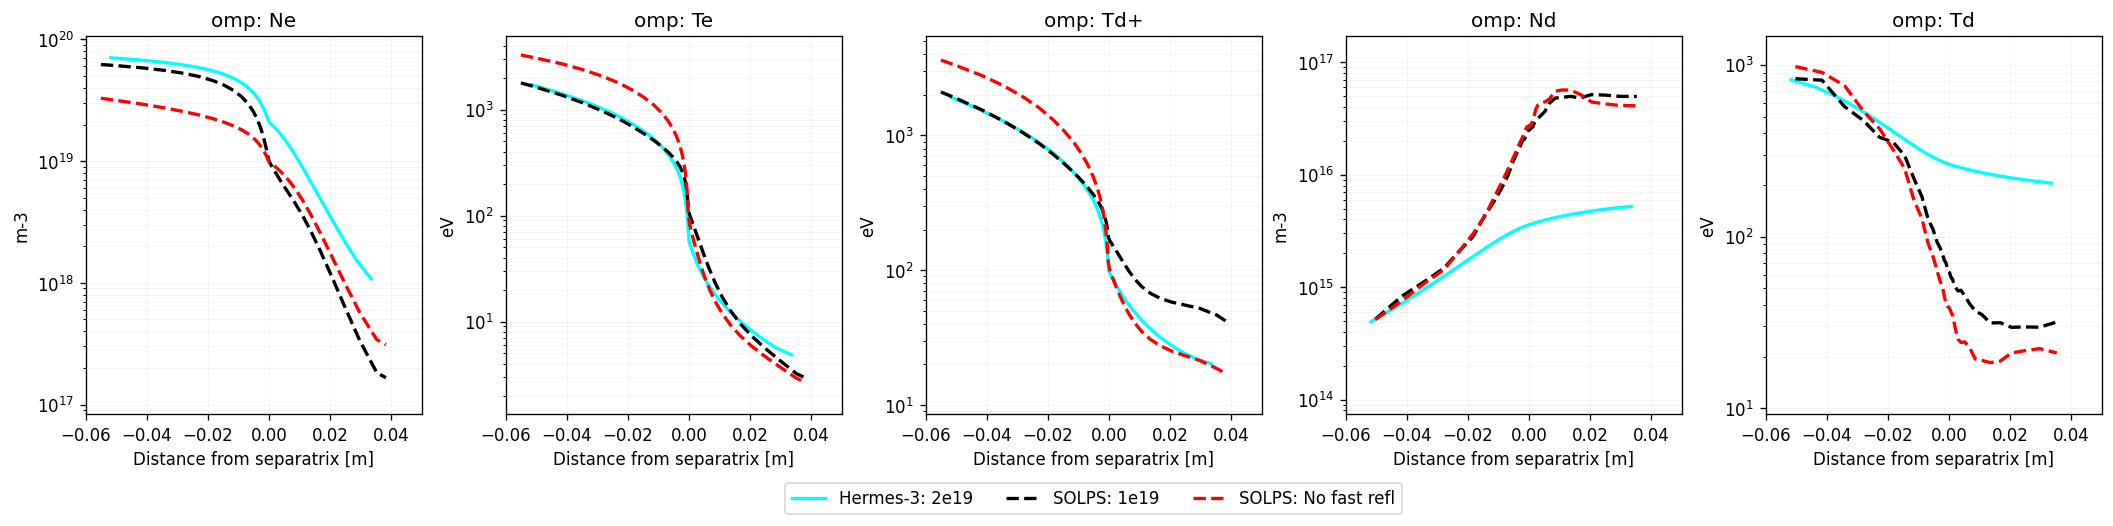

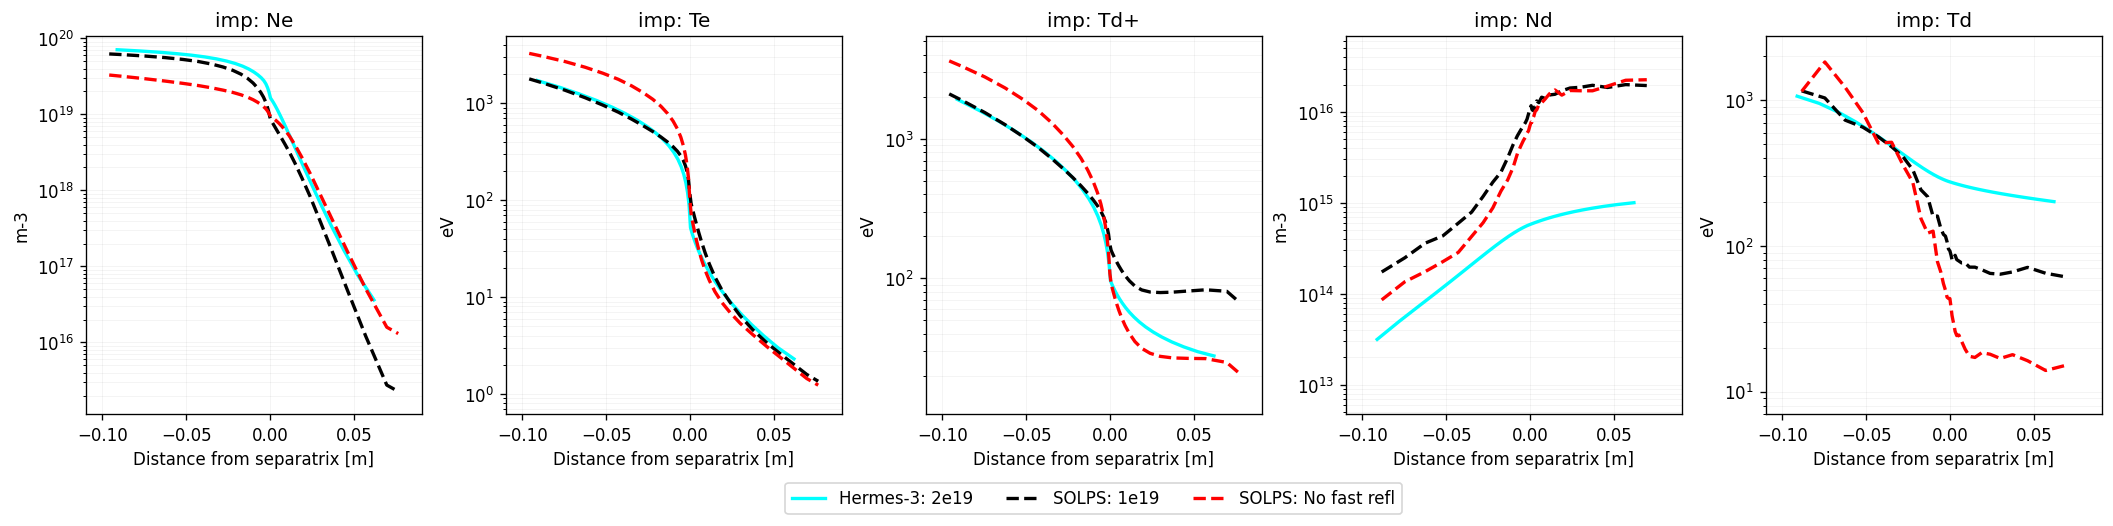

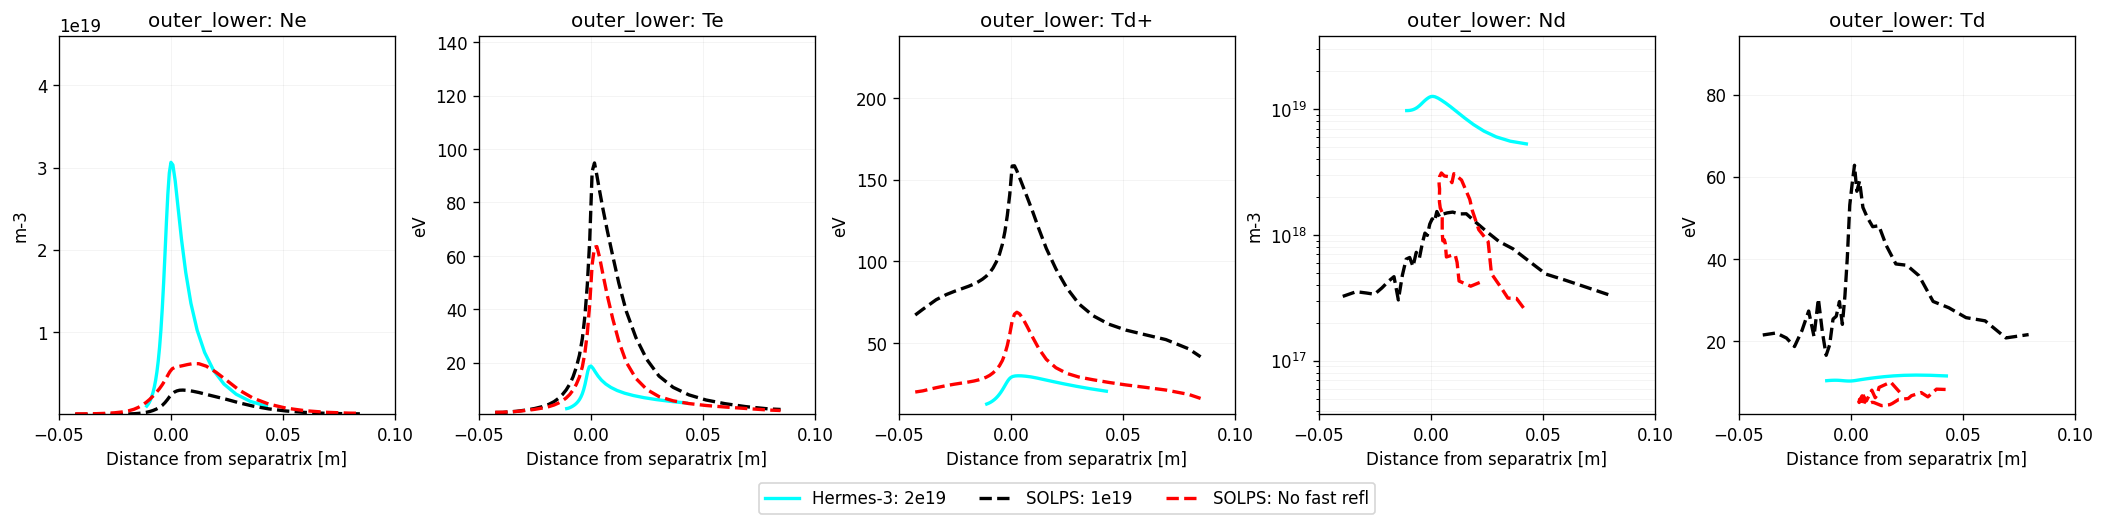

In [24]:

plt.close("all")
lineplot_compare(
    cases = { 

    # "Hermes-3: Neut refl. loss": dict(data=hr["base"], color = "cyan"),
    "Hermes-3: 2e19": dict(data=hr["fixes"], color = "cyan"),
    
    # "SOLEDGE: 1e19 (tight)" : dict(data=sl["tightwall_1e19"], color="#3288bd"),
    # "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    
    # "SOLEDGE: 1e19" : dict(data=sl["widewall_1e19"], color = "blue"),
    # "SOLEDGE: 2e19" : dict(data=sl["widewall_2e19"], color = "red")
    "SOLPS: 1e19" : dict(data=sp["noiz_core"], color="black"),
    "SOLPS: No fast refl" : dict(data=sp["no_fast_reflec"], color="red"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp"], params = ["Ne", "Nd",  "Te"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 120,
    lw = 2
)

### Conductive SOL heat balance

In [12]:

ds = casestore["fixes"].ds.isel(t=-1)
ds = calculate_radial_fluxes(ds)
hflows = {}


hflows["outer_sol"] = ds.hermesm.select_region("outer_sol_edge")["hf_perp_tot_R_d"].sum("theta").values * 1e-6
hflows["inner_sol"] = ds.hermesm.select_region("inner_sol_edge")["hf_perp_tot_L_d"].sum("theta").values * 1e-6
hflows["lower_pfr_edge"] = ds.hermesm.select_region("lower_pfr_edge")["hf_perp_tot_L_d"].sum("theta").values * 1e-6
hflows["upper_pfr_edge"] = ds.hermesm.select_region("upper_pfr_edge")["hf_perp_tot_L_d"].sum("theta").values * 1e-6
# plot_selection(ds, ds.hermesm.select_region("outer_sol_edge"))

tot = 0
for name in hflows:
    print(f"{name}: {hflows[name][0]:.3f}")
    tot += hflows[name]
    
print(f"Total: {tot[0]:.3f}")

outer_sol: 0.000
inner_sol: 0.009
lower_pfr_edge: 0.000
upper_pfr_edge: 0.000
Total: 0.009


In [34]:
hflows[name]

array([0.10038744])

# Pump manual mass balance

In [10]:
casestore["condwall"].ds = calculate_target_fluxes(casestore["condwall"].ds)

Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


KeyError: 'condwall'

In [14]:
ds_balance = casestore["halfcond"].ds.copy().isel(t=-1)
m = ds_balance.metadata

sol = ds_balance.hermesm.select_region("sol_edge")
pfr = ds_balance.hermesm.select_region("pfr_edge")
domain = ds_balance.hermesm.select_region("all_noguards")
core = ds_balance.hermesm.select_region("core_edge")

s = {}

# SOL
s["sol_src_i"] = sol["pf_perp_diff_R_d+"].sum(["x", "theta"]) * -1
s["sol_src_n"] = sol["pf_perp_diff_R_d"].sum(["x", "theta"]) * -1

# Core
s["core_src_i"] = core["pf_perp_diff_L_d+"].sum(["x", "theta"])
s["core_src_n"] = core["pf_perp_diff_L_d"].sum(["x", "theta"])

# PFR
s["pfr_src_i"] = pfr["pf_perp_diff_L_d+"].sum(["x", "theta"])
s["pfr_src_n"] = pfr["pf_perp_diff_L_d"].sum(["x", "theta"])

# Wall and pump recycle
s["pump_recycle"] = ((domain["Sd_pump_recycle"])*domain["dv"]).sum(["x", "theta"]) * m["Nnorm"] * m["Omega_ci"]
s["wall_recycle"] = ((domain["Sd_wall_recycle"])*domain["dv"]).sum(["x", "theta"]) * m["Nnorm"] * m["Omega_ci"]
# target_recycle = ((domain["Sd_target_recycle"])*domain["dv"]).sum(["x", "theta"])

s["target_src_i"] = 0
s["target_src_n"] = 0

for name in m["targets"]:
    target_name = f"{name}_target"
    s["target_src_i"] += ds_balance[f"pf_{target_name}_d+"].sum("x")
    s["target_src_n"] += ds_balance[f"pf_recycle_{target_name}_d"].sum("x")
    
targets_net = s["target_src_i"] + s["target_src_n"]

df = pd.DataFrame(columns = ["value"])
for name in s:
    df.loc[name, "value"] = s[name].values

KeyError: 'pf_perp_diff_R_d+'

In [13]:
def display_dataframe(df, format = "{:.2e}"):

    def styler(s):
            if abs(s) < 0.01 or pd.isna(s):
                c =  "color: lightgrey"
            else:
                c =  "color: black"

            return c
            
    ts = df.style.format("{:.2e}")
    ts = ts.applymap(styler)
    display(ts)
    


### Reflective neutrals balance

In [34]:
hr.keys()

dict_keys(['escapecore', 'condsol', 'neutralbc', 'gamma0.4', 'halfcond', 'pump', 'fixes'])

In [18]:
ds = casestore["fixes"].ds.isel(t=-1)
places = {}
places["outer_wall"] = ds.hermesm.select_region("outer_sol_edge")
places["inner_wall"] = ds.hermesm.select_region("inner_sol_edge")
places["pfr"] = ds.hermesm.select_region("pfr_edge")

hflows = {}
for place in places:
    ds_place = places[place]
    hflows[place] = ()
    hflows[place] = (ds_place["Ed_wall_refl"] * ds_place["dv"] ).sum().values * 1e-6
    
hflows["targets"] = (ds["Ed_target_refl"] * ds["dv"]).sum().values * 1e-6

In [19]:
tot = 0
for name in hflows:
    print(f"{name}: {hflows[name]:.3f}")
    tot += hflows[name]
    
print(f"Total: {tot:.3f}")

outer_wall: -0.138
inner_wall: -0.014
pfr: -0.069
targets: -0.031
Total: -0.252


In [21]:
for case in casestore:
    print(f">>>>{case}")
    calculate_simple_heat_balance(casestore[case].ds.isel(t=-1))

>>>>base
outer_wall: -0.229
inner_wall: -0.024
pfr: -0.001
targets: -0.024
Total: -0.278

>>>>fixes
outer_wall: -0.138
inner_wall: -0.014
pfr: -0.069
targets: -0.031
Total: -0.252



In [19]:
plt.close("all")
%matplotlib inline

In [17]:
for case in casestore:
    casestore[case].ds = calculate_radial_fluxes(casestore[case].ds)

Integrating poloidally


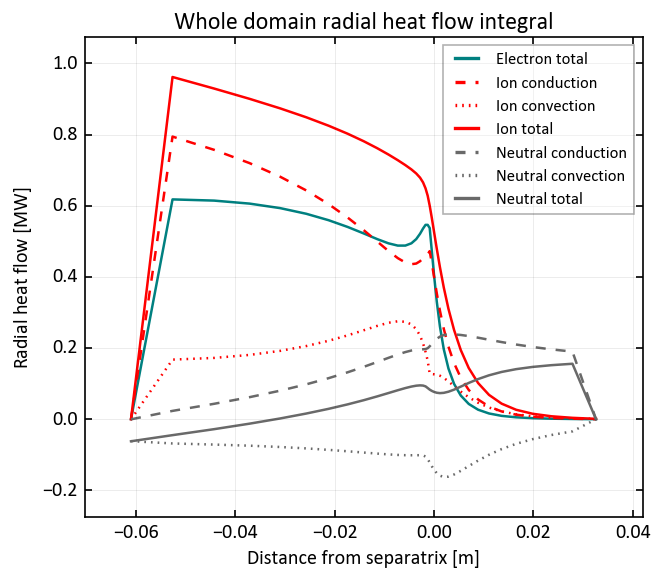

In [40]:
plot_perp_heat_fluxes(casestore["neutralbc"].ds.isel(t=-1), loc = "integral")

Text(0.5, 1.0, 'Perpendicular heat flows')

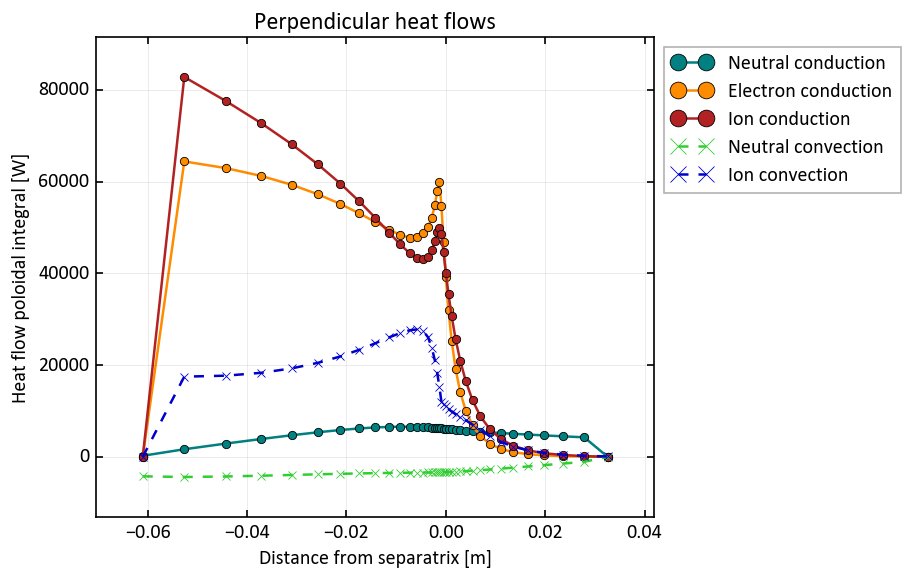

In [42]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\Lib\site-packages\matplotlib\mpl-data\stylelib\mike.mplstyle")

fig, ax = plt.subplots()

ds = casestore["neutralbc"].ds.isel(t=-1)


omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# d = ds.isel(x=slice(2,-2)).sum("theta")
d = omp

dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
dist = np.insert(dist.values, 0, dist.values[0] - (dist.values[1] - dist.values[0]))

def append_rhs(x):
    F = d[x]
    rhs = d[x.replace("_L_", "_R_")][-1].values
    return np.concatenate([F, [rhs]])

m = "o"
ms = 5
ax.plot(dist, append_rhs("hf_perp_diff_L_d"), label = "Neutral conduction", marker = m, ms = ms)
ax.plot(dist, append_rhs("hf_perp_diff_L_e"), label = "Electron conduction", marker = m, ms = ms)
ax.plot(dist, append_rhs("hf_perp_diff_L_d+"), label = "Ion conduction", marker = m, ms = ms)
ax.plot(dist, append_rhs("hf_perp_conv_L_d"), label = "Neutral convection", marker = "x",ls = "--", ms = ms)
ax.plot(dist, append_rhs("hf_perp_conv_L_d+"), label = "Ion convection", marker = "x",ls = "--", ms = ms)
fig.legend(loc = "upper left", bbox_to_anchor = (0.9,0.9))
# domain["hf_perp_diff_R_d"].plot(ax = ax, label = "Neutral conduction")
# domain["hf_perp_conv_R_d"].plot(ax = ax, label = "Neutral convection")
ax.set_ylabel("Heat flow poloidal integral [W]")
ax.set_xlabel("Distance from separatrix [m]")
ax.set_title("Perpendicular heat flows")

## Nd

In [50]:
%matplotlib inline

In [49]:
import sdtools.general.plotstyle

SOLEDGE: Combining Nmi and Nni


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


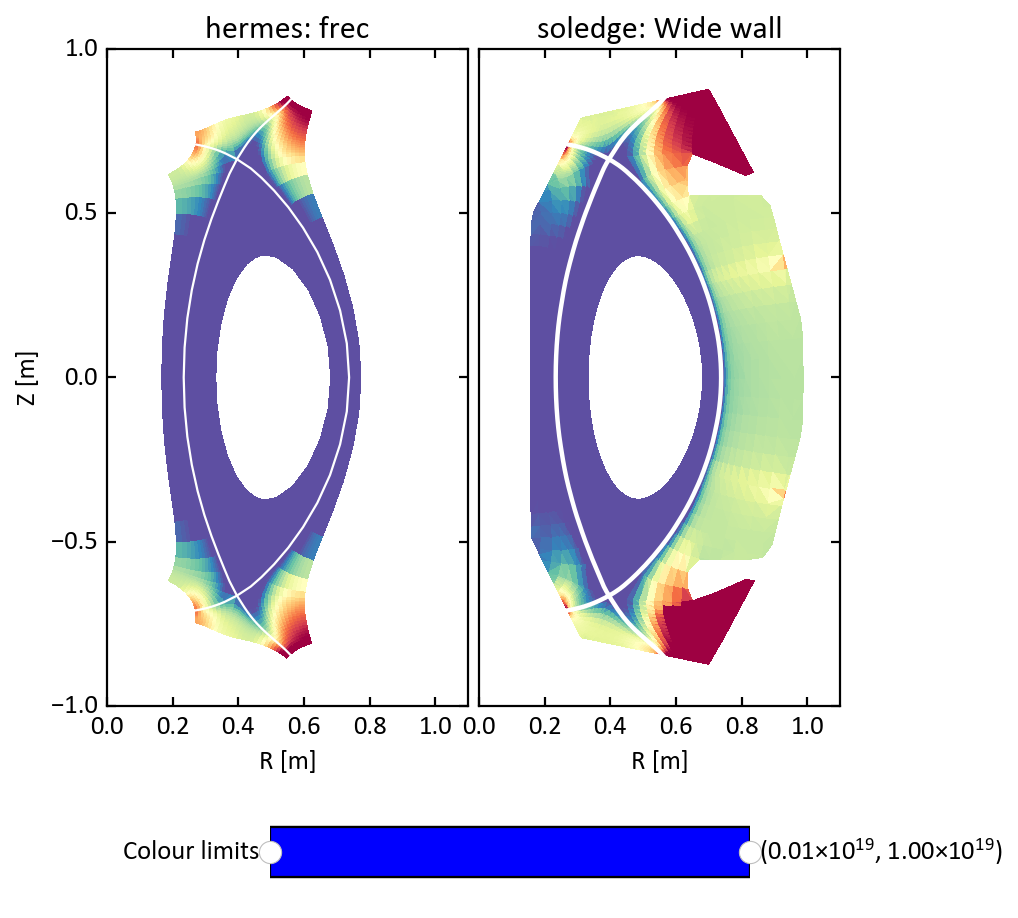

In [56]:
v = viewer_2d(
    "Nd",
    [
        {"name" : "frec", "code" : "hermes", "ds" : casestore["fastrec"].ds.isel(t=-1)},
        # {"name" : "tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "Wide wall", "code":"soledge", "path" : soledgecases["widewall_2e19"]}
    ],
    logscale = True,
    # vmin = 0,
    # vmax = 60,
    vmin = 1e17,
    vmax = 1e19,
    dpi = 160,
    ylim = (-1,1), #(-0.9,0.9),
    xlim = (0, 1.1), #(0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r",
    add_cbar = False
)

## Nd

## Nd

In [41]:
casestore.keys()

dict_keys(['base', 'fastrec'])

In [45]:
%matplotlib widget

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


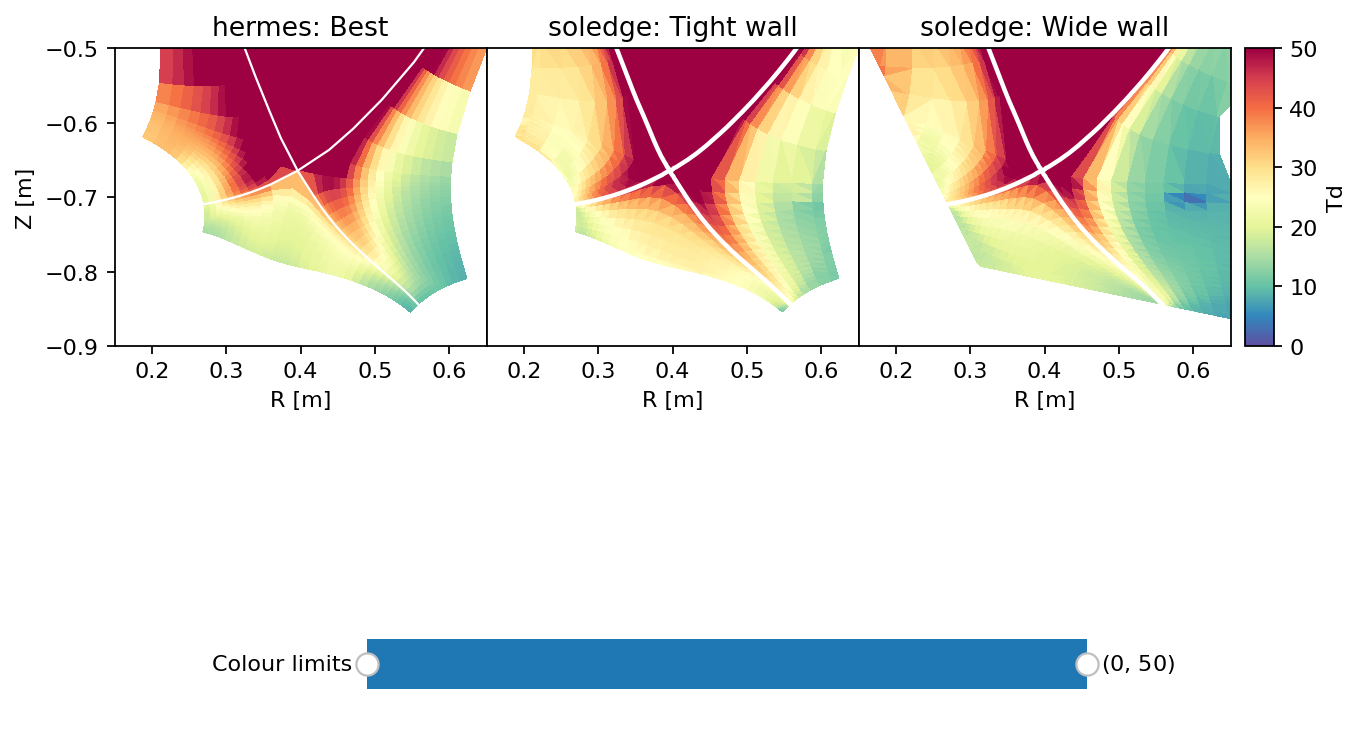

In [18]:
plt.close("all")
v = viewer_2d(
    "Td",
    [
        # {"name" : "Best", "code" : "hermes", "ds" : casestore["base"].ds.isel(t=-1)},
        {"name" : "Best", "code" : "hermes", "ds" : casestore["fastrec"].ds.isel(t=-1)},
        {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "Wide wall", "code":"soledge", "path" : soledgecases["widewall_2e19"]}
    ],
    logscale = False,
    vmin = 0,
    vmax = 50,
    # vmin = 1e17,
    # vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,-0.5),
    xlim = (0.15, 0.65),
    wspace = 0.0,
    cmap = "Spectral_r"
)

SOLEDGE: Combining Nmi and Nni


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


SOLEDGE: Combining Nmi and Nni


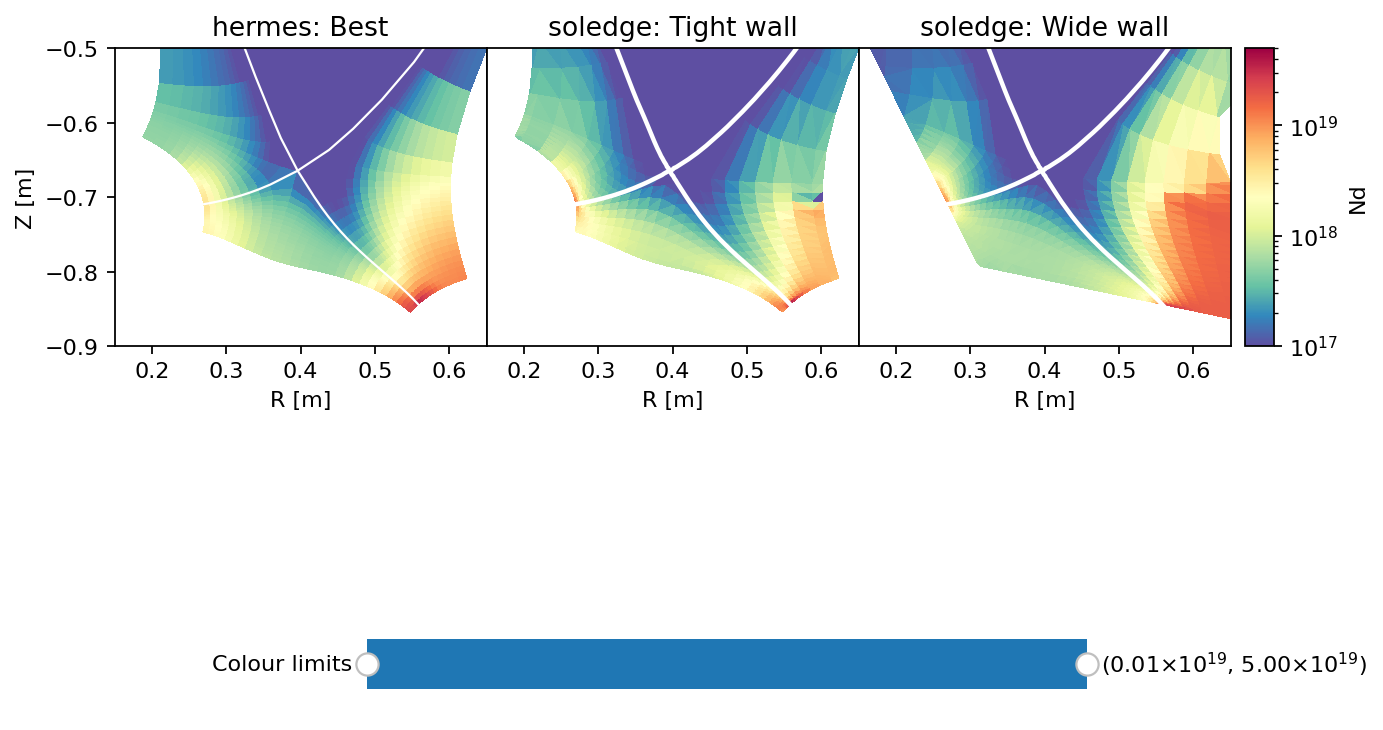

In [23]:
plt.close("all")
v = viewer_2d(
    "Nd",
    [
        # {"name" : "Best", "code" : "hermes", "ds" : casestore["base"].ds.isel(t=-1)},
        {"name" : "Best", "code" : "hermes", "ds" : casestore["fastrec"].ds.isel(t=-1)},
        {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "Wide wall", "code":"soledge", "path" : soledgecases["widewall_2e19"]}
    ],
    logscale = True,
    # vmin = 0,
    # vmax = 50,
    vmin = 1e17,
    vmax = 5e19,
    dpi = 160,
    ylim = (-0.9,-0.5),
    xlim = (0.15, 0.65),
    wspace = 0.0,
    cmap = "Spectral_r"
)

# Poloidal plot dev

In [ ]:
from code_comparison.solps_pp import *
params = ["Ne"]


self = SOLPScase(solpscases["nsep_2e19"])

region = "outer"
dist_from_sep = 0.001

if "outer" in region:
    radial_locator = self.s["omp"]
elif "inner" in region:
    radial_locator = self.s["imp"]
else:
    raise Exception(f"Region {region} not recognised")

p = radial_locator
radial_dist = self.g["R"][p[0], p[1]] - self.g["R"][p[0], self.g["sep"]] 
ring_index = np.argmin(abs(dist_from_sep - radial_dist))
ring_from_sep = ring_index - self.g["sep"]
print(f"Distance {dist_from_sep} corresponds to SOL ring {ring_from_sep}")    

# Get slice of the separatrix for the requested region
p = self.s[region]
p[1] += ring_from_sep   # Advance to desired SOL ring

poloidal_dist = 

dpi = 150
fig, axes = plt.subplots(2,len(params), dpi = dpi, figsize = (4.2*len(params),5), sharex = True)
fig.subplots_adjust(hspace = 0, wspace = 0.25, bottom = 0.25, left = 0.1, right = 0.9)

ax = axes[0]
ax.plot(dist, self.bal["ne"][:][p[0], p[1]])

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


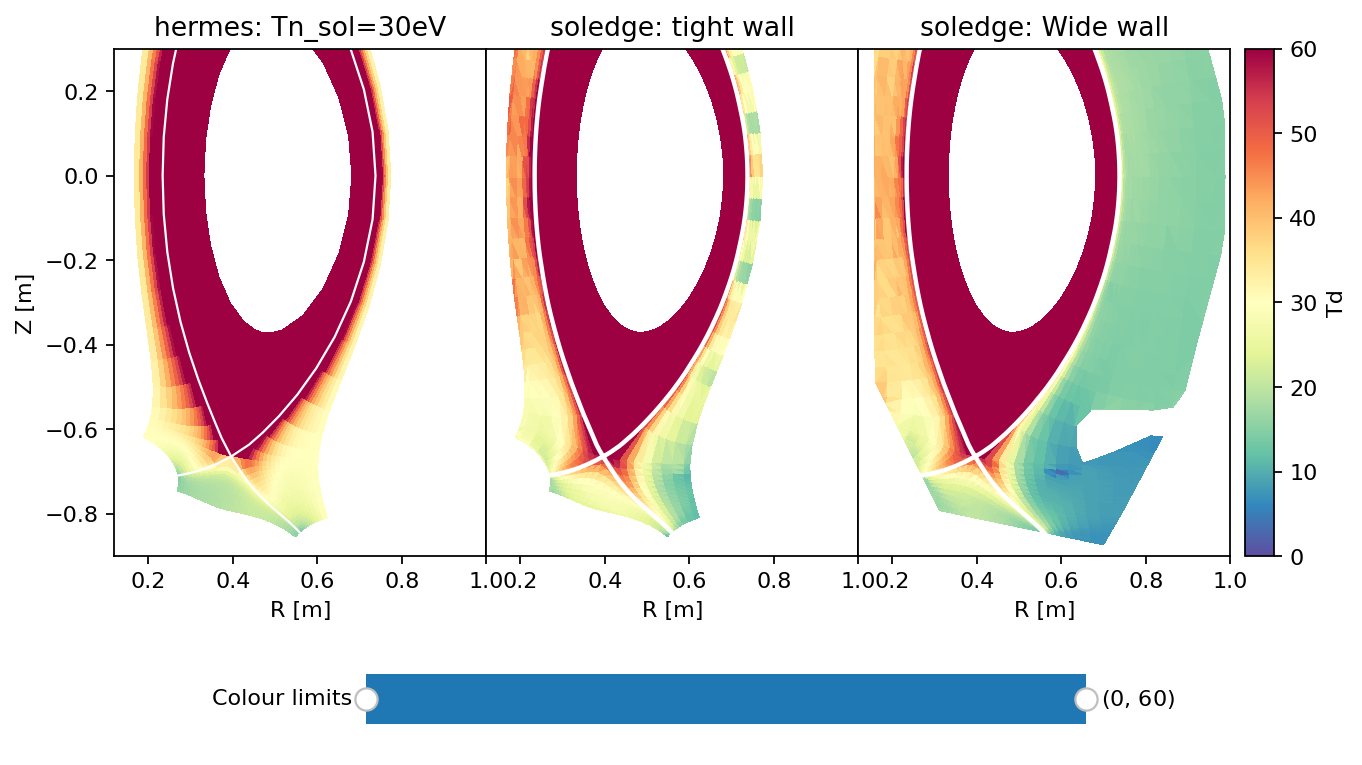

In [31]:
v = viewer_2d(
    "Td",
    [
        {"name" : "Tn_sol=30eV", "code" : "hermes", "ds" : casestore["2e19"].ds.isel(t=-1)},
        {"name" : "tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "Wide wall", "code":"soledge", "path" : soledgecases["widewall_2e19"]}
    ],
    logscale = False,
    vmin = 0,
    vmax = 60,
    # vmin = 1e16,
    # vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,0.3),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)

# PFR cooling check

In [11]:
plt.close("all")
%matplotlib inline

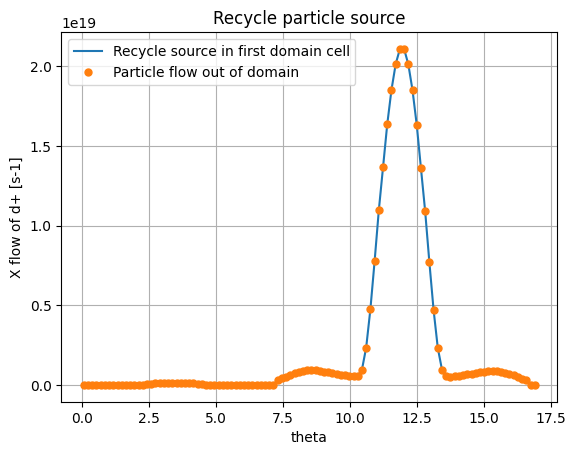

In [18]:
m = ds.metadata
norm = m["Nnorm"] * m["Omega_ci"]
(ds["Sd_wall_recycle"] * norm * ds["dv"]).isel(x=-3).plot(label = "Recycle source in first domain cell")
(ds["ParticleFlow_d+_xlow"].isel(x=-2)).plot(label = "Particle flow out of domain", lw = 0, marker = "o", ms = 5)
plt.legend()
plt.title("Recycle particle source")
plt.grid()
# ds["Sd_target_recycle"].isel(x=-3).plot()

# Reflective BC test

## Check SOL


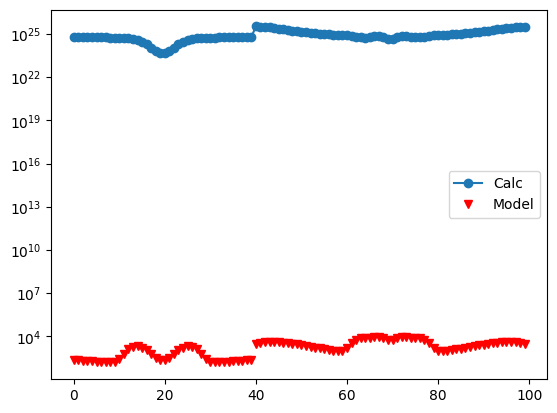

In [43]:
ds = casestore["neutralbc"].ds.isel(t=-1)

calc = []
model = []

d = ds.hermesm.select_region("sol_edge")

    
vth = np.sqrt( (constants("q_e") * d["Td"]) / (constants("mass_p")*2))
q = 0.3 * d["Nd"] * d["Td"] * vth  # Wm-2
da = d["dl"] * (d["dz"] * np.sqrt(d["g_33"] * m["rho_s0"]**2))  # m2. Right now g_33 has no norm, but I just changed it!!
Q = q * da  # W
source = Q / d["dv"]

calc = source.squeeze().values
model = (d["Ed_wall_refl"] *  d["dv"]).squeeze().values

fig, ax = plt.subplots()
ax.plot(calc, marker = "o", label = "Calc")
ax.plot(-model, lw = 0, marker = "v", label = "Model", c = "r")
ax.legend()
ax.set_yscale("log")

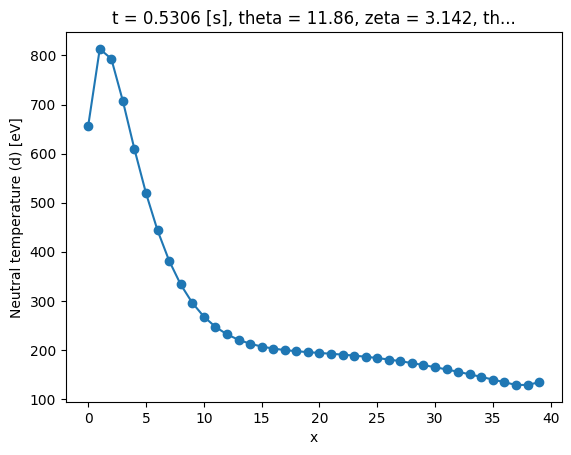

In [45]:
omp  = ds.hermesm.select_region("outer_midplane_a")

omp["Td"].plot(marker = "o")

Total PFR ion particle flux: 0.000e+00
Total PFR recycle source: 0.000e+00


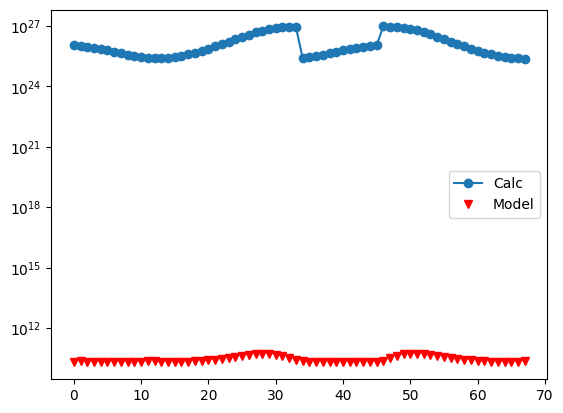

In [32]:
ds = casestore["neutralbc"].ds.isel(t=-1)

calc = []
model = []
tflux_ions = 0
tflux_recycle = 0
norm = constants("q_e") * m["Nnorm"] * m["Tnorm"] * m["Omega_ci"]

for name in ["lower_pfr_edge", "upper_pfr_edge"]:
    pf = ds.hermesm.select_region(name)
    
    vth = np.sqrt( (constants("q_e") * pf["Td"]) / (constants("mass_p")*2))
    q = 0.3 * pf["Nd"] * pf["Td"] * vth  # Wm-2
    da = pf["dl"] * pf["R"] * 2 * np.pi  # m2
    Q = q * da  # W
    source = Q / (pf["J"] * pf["dx"] * pf["dy"] * pf["dz"])
    
    calc.append((source).squeeze().values)
    model.append((pf["Ed_wall_refl"] * norm * ds["dv"]).squeeze().values)
    
    # tflux_ions += (pfr_edge["ParticleFlow_d+_xlow"] ).values.sum()
    # tflux_recycle += (pfr_edge["Ed_wall_refl"]* norm * pfr_edge["dv"]).values.sum()
    
print(f"Total PFR ion particle flux: {tflux_ions:.3e}")
print(f"Total PFR recycle source: {tflux_recycle:.3e}")
calc = np.concatenate(calc)
model = np.concatenate(model)

fig, ax = plt.subplots()
ax.plot(calc, marker = "o", label = "Calc")
ax.plot(-model, lw = 0, marker = "v", label = "Model", c = "r")
ax.legend()
ax.set_yscale("log")

Total PFR ion particle flux: -4.203e+19
Total PFR recycle source: 4.203e+19


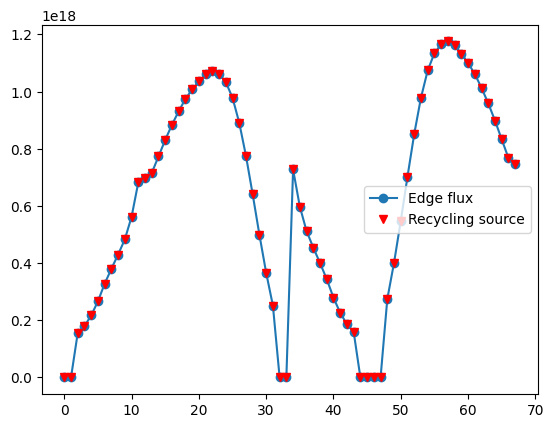

In [19]:
ds = casestore["neutralbc"].ds.isel(t=-1)

fluxes = []
sources = []
tflux_ions = 0
tflux_recycle = 0

for name in ["lower_pfr_edge", "upper_pfr_edge"]:
    pfr_edge = ds.hermesm.select_region(name)
    fluxes.append((pfr_edge["ParticleFlow_d+_xlow"] * -1).squeeze().values)
    sources.append((pfr_edge["Sd_wall_recycle"]* norm * ds["dv"]).squeeze().values)
    
    tflux_ions += (pfr_edge["ParticleFlow_d+_xlow"] ).values.sum()
    tflux_recycle += (pfr_edge["Sd_wall_recycle"]* norm * pfr_edge["dv"]).values.sum()
    
print(f"Total PFR ion particle flux: {tflux_ions:.3e}")
print(f"Total PFR recycle source: {tflux_recycle:.3e}")
fluxes = np.concatenate(fluxes)
sources = np.concatenate(sources)

fig, ax = plt.subplots()
ax.plot(fluxes, marker = "o", label = "Edge flux")
ax.plot(sources, lw = 0, marker = "v", label = "Recycling source", c = "r")
ax.legend()
# (ds["ParticleFlow_d+_xlow"].isel(x=2) * nfluxnorm * -1).plot(label = "L flow in inner guard cell into domain", lw = 0, marker = "o", ms = 5)
# plt.legend()
# plt.title("Recycle particle source")
# plt.grid()
# # ds["Sd_target_recycle"].isel(x=-3).plot()